In [2]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [3]:
data_dir = Path("/media/wwymak/Storage/xView2")
mask_dir = data_dir /"mask_full_size"
models_path = data_dir / "models"
train_images_crops = data_dir/"train_crops"
mask_dir_edt = data_dir /"mask_full_size_edt"
train_mask_crops = data_dir/"mask_crops_single_channel"
label_dir = data_dir/"train"/"labels"
mask_crops_edt = data_dir/"mask_crops_edt"

In [39]:
mask_dir_edt.ls()[0]

PosixPath('/media/wwymak/Storage/xView2/mask_full_size_edt/midwest-flooding_00000319_pre_disaster.png')

In [63]:
images = [data_dir / "train" / "images"/x for x in os.listdir(data_dir / "train" / "images") if 'post_disaster' in x]
labels = [data_dir / "train" / "labels"/(x.name.replace('png', 'json')) for x in images]
masks_fnames = [mask_dir_edt/(x.name) for x in images]
len(images)

2799

In [8]:
import geopandas as gpd
def parse_label_json(label_json):
    
    df_xy = pd.DataFrame([{'id': x['properties']['uid'], 'feature': x['properties']['feature_type'],
                           'damage': x['properties'].get('subtype', 'no-damage'),
                           'geometry_pixel': x['wkt']} for x in label_json['features']['xy']])
    df_lnglat = pd.DataFrame(
        [{'id': x['properties']['uid'], 'geometry_lnglat': x['wkt'], } for x in label_json['features']['lng_lat']])
    if len(df_xy) == 0:
        return
    df_xy.set_index('id', inplace=True)

    df_xy['damage_cls'] = df_xy['damage'].map({
        'no-damage': 1, 'minor-damage': 2, 'major-damage': 3, 'destroyed': 4, 'un-classified': 5
    })
    df_xy.geometry_pixel = df_xy.geometry_pixel.apply(wkt.loads)
    df_lnglat.set_index('id', inplace=True)
    label_df = df_xy.merge(df_lnglat['geometry_lnglat'], left_index=True, right_index=True)
    label_gdf = gpd.GeoDataFrame(label_df, geometry='geometry_pixel')
    label_gdf['centroid'] = label_gdf.geometry_pixel.centroid
    return label_gdf

In [10]:
label_file = labels[0]
with open(label_file, 'r') as f:
    label = json.load(f)
label_gdf = parse_label_json(label)
label_gdf.iloc[0]

feature                                                     building
damage                                                     no-damage
geometry_pixel     POLYGON ((1005.249981247345 934.6299999080635,...
damage_cls                                                         1
geometry_lnglat    POLYGON ((119.8772266625271 -0.795167260292315...
centroid                   POINT (996.59771479529 948.3746730924687)
Name: 93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8, dtype: object

In [37]:
def process_img(img_array, polygon_pts, scale_pct):
    """Process Raw Data into
            Args:
                img_array (numpy array): numpy representation of image.
                polygon_pts (array): corners of the building polygon.
            Returns:
                numpy array: .
    """

    height, width, _ = img_array.shape

    xcoords = polygon_pts[:, 0]
    ycoords = polygon_pts[:, 1]
    xmin, xmax = np.min(xcoords), np.max(xcoords)
    ymin, ymax = np.min(ycoords), np.max(ycoords)

    xdiff = xmax - xmin
    ydiff = ymax - ymin

    # Extend image by scale percentage
    xmin = max(int(xmin - (xdiff * scale_pct)), 0)
    xmax = min(int(xmax + (xdiff * scale_pct)), width)
    ymin = max(int(ymin - (ydiff * scale_pct)), 0)
    ymax = min(int(ymax + (ydiff * scale_pct)), height)

    return img_array[ymin:ymax, xmin:xmax, :]

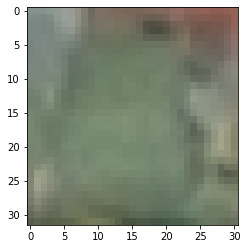

In [55]:
plt.imshow(process_img(np.array(PIL.Image.open(images[0])), coords, 0.1))

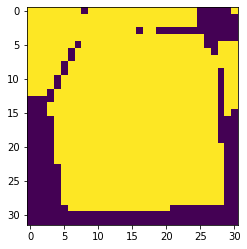

In [54]:
plt.imshow(process_img(np.array(PIL.Image.open('/media/wwymak/Storage/xView2/mask_full_size_single_channel/palu-tsunami_00000024_pre_disaster.png'))[..., None], coords,0.1).squeeze())

In [16]:
minimum_bounding_rectangle(coords)

array([[1009.029981,  960.18    ],
       [1007.589235,  933.870432],
       [ 982.611791,  935.238229],
       [ 984.052537,  961.547797]])